# Bits of Pandas + NLP + ML

This tutorial will use natural language processing and unsupervised learning to find the thematic topics of the research abstracts submitted to UK's Research Councils for funding.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import ast
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append('../im_tutorials/features/')
from text_preprocessing import *
from document_vectors import document_vector
from dim_reduction import WrapTSNE, GaussianMixtureEval

sys.path.append('../im_tutorials/')
from utilities import flatten_lists

In [3]:
list_cols = ['research_topics', 'research_subjects']
gtr_projects_df = pd.read_csv("https://s3.us-east-2.amazonaws.com/innovation-mapping-tutorials/gateway-to-research/gtr_projects.csv",
                              converters={k: ast.literal_eval for k in list_cols})

# Drop duplicates
gtr_projects_df.drop_duplicates('project_id', inplace=True)

In [4]:
# Shape of our data
gtr_projects_df.shape

(42584, 7)

In [5]:
# Missing values
gtr_projects_df.isnull().sum()

Unnamed: 0            0
project_id            0
start_year            0
research_topics       0
research_subjects     0
abstract_texts       12
funder_name           0
dtype: int64

In [6]:
# Drop missing data
gtr_projects_df.dropna(inplace=True)

In [7]:
gtr_projects_df.head()

,Unnamed: 0,project_id,start_year,research_topics,research_subjects,abstract_texts,funder_name
0,0,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B391...,2010,[Statistics & Appl. Probability],[Mathematical sciences],Random fields of gradients are a class of mode...,EPSRC
1,1,http://gtr.rcuk.ac.uk:80/gtr/api/projects/B3F5...,2016,"[Political Science, European/EU Studies, Polit...",[Pol. sci. & internat. studies],Can the EU govern efficiently and with the peo...,ESRC
2,2,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D894...,2008,"[Materials Characterisation, High Performance ...","[Materials sciences, Supercond, magn. &quant.f...",Many technological advances in modern day life...,EPSRC
3,3,http://gtr.rcuk.ac.uk:80/gtr/api/projects/D99D...,2006,"[Management & Business Studies, Economic & Soc...","[Management & Business Studies, History, Econo...",<p>This research programme groups together 7 p...,ESRC
4,4,http://gtr.rcuk.ac.uk:80/gtr/api/projects/4756...,2013,"[Phenomenology, The Standard Model, Beyond the...","[Particle physics - experiment, Particle Astro...",Experimental particle physics addresses fundam...,STFC


## Text preprocessing

### Some definitions

**Tokenisation:** It is a particular kind of document segmentation. Segmentation breaks up text into smaller chunks or segments, with more focused information content. Tokens are instances of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing.  
**Vocabulary:** A collection of the unique tokens found in a collection of documents.  
**One-hot-vectors:** A representation of tokens as binary vectors. The length of the vector is equal to the size of the vocabulary.  

<img src="../reports/figures/onehot.png" width="600">

### Goal

We will clean the abstract of every research project. 

We will:
* Lowercase and tokenise the documents.
* Keep only tokens that have more than two characters.
* Filter out stop words, punctuation, numeric and non-English characters.
* Create n-grams.

Other things that you could try:
* Change the regular expression used to tokenise the documents.
* Stem or lemmatise tokens based on their Part-of-Speech tag.

In [8]:
%%time
# Process the abstracts
gtr_projects_df['processed_documents'] = build_ngrams([flatten_lists(tokenize_document(document)) for document in list(gtr_projects_df.abstract_texts)])

CPU times: user 2min 4s, sys: 721 ms, total: 2min 4s
Wall time: 2min 4s


In [9]:
# Binary column showing if a document has any tokens left after preprocessing
gtr_projects_df['is_Doc'] = gtr_projects_df.processed_documents.apply(lambda doc: 1 if len(doc) != 0 else 0)

# Keep only rows with a processed abstract
gtr_projects_df = gtr_projects_df[gtr_projects_df.is_Doc == 1]

## Create word vectors

We will use [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) to create a dense vector representation of tokens and project them to a low-dimensional vector space. This is done in a way that similar tokens will be closer on the vector space.

#### Why not using something simpler?
Few disadvantages of one-hot-vectors:
* Very high dimensionality -> takes longer to train ML models.
* They do not learn based on their context, meaning that we cannot find relations between tokens.

<img src="../reports/figures/onehotencoding.png">

#### What's word2vec?

Word2Vec is a shallow neural network which takes as input a large collection of sentences and produces a vector space of words, typically of several hundred dimensions where each word is assigned to corresponding vector in the space. Word vectors are positioned in the vector space in a way that those sharing similar context are located in close proximity to one another in the high dimensional vector space.  

Word2Vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text.

#### Architecture

<img src="../reports/figures/w2v_architectures.png" width="800">

#### Word2vec: Few important hyperparameters
* **`size`**: Dimensionality of the word vectors (length of the hidden layer).
* **`min_count`**: Ignores all words with total frequency lower than this.
* **`window`**: Maximum distance between the current and predicted word within a sentence.
* **`learning rate`**: The learning rate used in training.
* We can choose between the **`skip-gram`** and **`Continuous BOW`** implementation of the algorithm.
* We can choose **`Hierachical Softmax`** or **`Negative Sampling`** to train of the algorithm.


Other methods you could use:
* One-hot-encodings
* [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [GloVe](https://nlp.stanford.edu/projects/glove/)
* [fastText](https://fasttext.cc/)
* [ELMo](https://allennlp.org/elmo)

In [10]:
%%time
w2v = gensim.models.Word2Vec(list(gtr_projects_df.processed_documents), size=300, window=10, min_count=2, iter=20)

CPU times: user 10min 46s, sys: 2.38 s, total: 10min 49s
Wall time: 3min 43s


### Some examples of word2vec

In [11]:
w2v.wv.most_similar(['virtual_reality'])

[('listening', 0.7098560333251953),
 ('augmented_reality', 0.7093266844749451),
 ('virtual_environments', 0.7090843915939331),
 ('interactive', 0.7086695432662964),
 ('audio_visual', 0.6993733048439026),
 ('audio', 0.698796272277832),
 ('animation', 0.6947512626647949),
 ('computer_generated', 0.6928922533988953),
 ('interactively', 0.6875278353691101),
 ('immersive', 0.6866039037704468)]

In [12]:
w2v.wv.most_similar(['blockchain'])

[('digital_technology', 0.6527150869369507),
 ('high_street', 0.6498782634735107),
 ('users_needs', 0.6496659517288208),
 ('mobile_technology', 0.6477912664413452),
 ('products_services', 0.6439954042434692),
 ('tradeable', 0.636365532875061),
 ('distributed_ledger', 0.6357883214950562),
 ('proof_of_concept_platform', 0.6347942352294922),
 ('open_data', 0.631662905216217),
 ('social_enterprises', 0.6311872005462646)]

In [13]:
w2v.wv.most_similar(['artificial_intelligence'])

[('computer_science', 0.8447680473327637),
 ('software_engineering', 0.8164826035499573),
 ('machine_learning', 0.8057308197021484),
 ('information_retrieval', 0.7931807041168213),
 ('cryptography', 0.792790412902832),
 ('automated_reasoning', 0.7903317809104919),
 ('multi_agent_systems', 0.7900739312171936),
 ('programming_languages', 0.788378119468689),
 ('natural_language', 0.784142255783081),
 ('computer_vision', 0.7838260531425476)]

In [14]:
w2v.wv.most_similar(['machine_learning'])

[('data_mining', 0.8233281970024109),
 ('artificial_intelligence', 0.8057308197021484),
 ('computer_vision', 0.8048868179321289),
 ('algorithms', 0.7911344766616821),
 ('natural_language', 0.7902688980102539),
 ('inference', 0.7660742402076721),
 ('computer_based', 0.7659111618995667),
 ('software_engineering', 0.7646470069885254),
 ('signal_processing', 0.7619490623474121),
 ('support_vector', 0.7600836753845215)]

In [15]:
w2v.wv.most_similar(['big_data'])

[('analytics', 0.7381346225738525),
 ('cloud_computing', 0.7197622060775757),
 ('data_management', 0.7116915583610535),
 ('data_sources', 0.6964896321296692),
 ('digital_data', 0.6904358863830566),
 ('data_sharing', 0.6866320371627808),
 ('data_driven', 0.682693600654602),
 ('information_systems', 0.6803810596466064),
 ('data_integration', 0.6802446842193604),
 ('visualisations', 0.6724504232406616)]

## Create document vectors

We average the word vectors of a document to create document vectors. The words that are not in word2vec model's vocabulary are ignored.

Other methods you could use:
* Averaged word vectors weighted by their TF-IDF.
* [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
* [sent2vec](https://rare-technologies.com/sent2vec-an-unsupervised-approach-towards-learning-sentence-embeddings/)

In [18]:
gtr_projects_df = gtr_projects_df[gtr_projects_df.funder_name.isin(['EPSRC', 'AHRC'])]

# Average word vectors
doc_vecs = [document_vector(doc=processed_document, word2vec_model=w2v) for processed_document in list(gtr_projects_df.processed_documents)]

## Cluster vectorised documents 

### t-SNE
t-SNE is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data in a low-dimensional space (usually 2D).  

In the high-dimensional space, t-SNE creates a probability distribution that dictates the relationships between various neighbouring points. Then, it tries to recreate a low dimensional space that follows that probability distribution as best as possible.

<img src="../reports/figures/tsne.png" width="800">

#### t-SNE: Few important hyperparameters
* **`n_components`**: Dimension of the embedded space.
* **`perplexity`:** The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter. The performance of t-SNE is fairly robust under different settings of the perplexity. 
* **`learning_rate`:** If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

### Gaussian Mixtures
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

<img alt="Credit: KazukiAmakawa [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)]" src="../reports/figures/gaussian_mixture.gif" width="800">

#### GMM: Few important hyperparameters
* **`n_components`**: The number of mixture components.
* **`covariance_type`**: The type of covariance to use.

<img src="../reports/figures/covariance_types.png" width="800">

What we will do:
* Find the cosine distance of the document vector matrix.
* Reduce its dimensionality to 2D using [t-SNE](https://lvdmaaten.github.io/tsne/).
* Cluster the points of the 2D space using [Gaussian Mixtures](https://scikit-learn.org/stable/modules/mixture.html)

Other methods we could use:
* PCA (for dimensionality reduction)
* k-Means (for clustering)

In [19]:
%%time
# Dimensionality reduction with t-SNE
ts = WrapTSNE()
tsne_space = ts.reduce_dimensions(doc_vecs, n_iter=500)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 17095 samples in 0.128s...
[t-SNE] Computed neighbors for 17095 samples in 4.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17095
[t-SNE] Computed conditional probabilities for sample 2000 / 17095
[t-SNE] Computed conditional probabilities for sample 3000 / 17095
[t-SNE] Computed conditional probabilities for sample 4000 / 17095
[t-SNE] Computed conditional probabilities for sample 5000 / 17095
[t-SNE] Computed conditional probabilities for sample 6000 / 17095
[t-SNE] Computed conditional probabilities for sample 7000 / 17095
[t-SNE] Computed conditional probabilities for sample 8000 / 17095
[t-SNE] Computed conditional probabilities for sample 9000 / 17095
[t-SNE] Computed conditional probabilities for sample 10000 / 17095
[t-SNE] Computed conditional probabilities for sample 11000 / 17095
[t-SNE] Computed conditional probabilities for sample 12000 / 17095
[t-SNE] Computed conditional probabilities for sa

In [20]:
# Clustering with GMM
# Instantiate the class using the 2D space from t-SNE
np.random.seed(42)
gmm_eval = GaussianMixtureEval(tsne_space)

best_gmm, bic = gmm_eval.fit_eval(max_components=50)
print('BEST GMM MODEL: {}'.format(best_gmm))

BEST GMM MODEL: GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=45, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)


In [21]:
# Predict token clusters based on best_gmm
token_labels = best_gmm.predict(tsne_space)

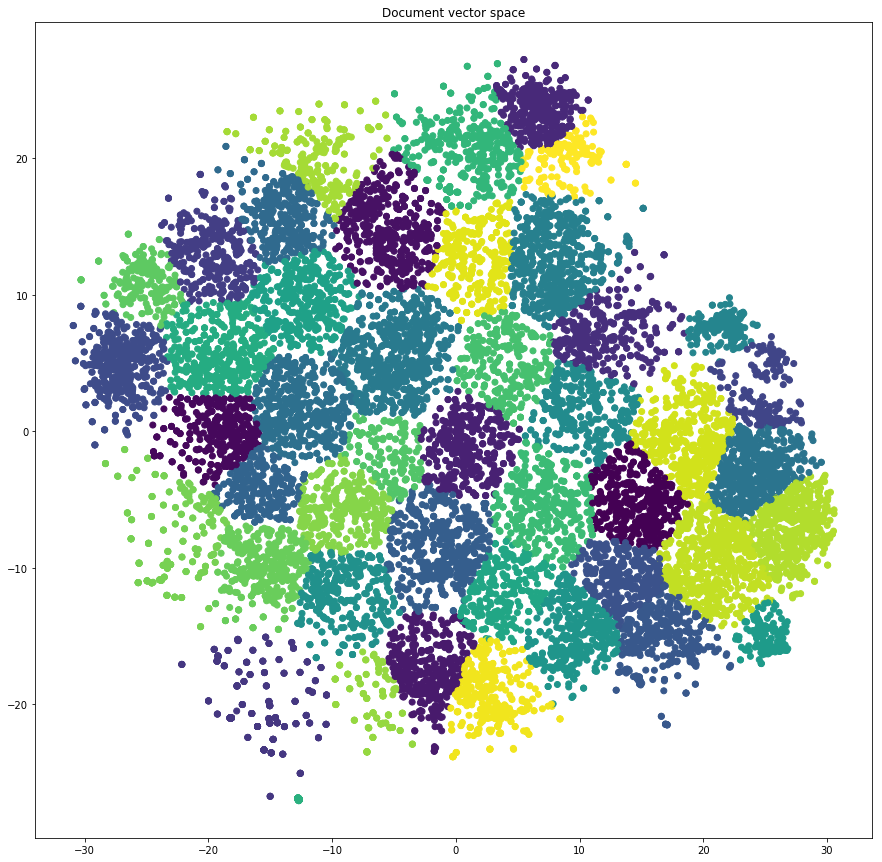

In [25]:
plt.figure(figsize=(15,15))
plt.scatter(tsne_space[:,0], tsne_space[:,1], c=token_labels)
plt.title('Document vector space')
plt.show()